# Facial Expression Recognition with Transfer Learning

This program performs **facial expression recognition** using **transfer learning** with a pre-trained **ResNet-18** model. The dataset consists of images categorized into 8 different facial expressions:
1. **Anger**
2. **Contempt**
3. **Disgust**
4. **Fear**
5. **Happy**
6. **Neutral**
7. **Sad**
8. **Surprised**

## Steps in the Program:
1. **Import Libraries and Setup**: Import necessary Python libraries and set up the device (CPU or GPU) for computations.
2. **Dataset Preparation**:
   - Load and preprocess image data using a custom PyTorch `Dataset`.
   - Normalize and resize the images.
   - Use `DataLoader` for batch processing.
3. **Load Pre-trained Model**:
   - Load **ResNet-18** from `torchvision`.
   - Modify the final fully connected layer to adapt to the 8-class classification task.
4. **Model Compilation**:
   - Define loss function (`NLLLoss`) and optimizer (`Adam`).
5. **Training and Validation**:
   - Train the model while tracking performance metrics (accuracy and loss).
   - Evaluate the model on the validation dataset.
6. **Visualization**:
   - Plot the accuracy and loss trends over the training epochs.

## Model Architecture:
- **Pre-trained Backbone**: ResNet-18 (trained on ImageNet) is used for feature extraction. Layers are frozen to prevent re-training on the current dataset.
- **Custom Fully Connected Layers**:
  - Linear layer with 256 hidden units.
  - ReLU activation function.
  - Dropout (50%) for regularization.
  - Final linear layer with 8 output units for classification into 8 facial expression categories.
  - LogSoftmax for output probability distribution.

## Expected Outcome:
The model should be able to classify facial expressions with reasonable accuracy. Transfer learning leverages pre-trained features, reducing the need for large datasets and extensive training time.


# Model Architecture: ResNet-18 with Custom Classification Head

The architecture of the model used is based on **ResNet-18**, a convolutional neural network pre-trained on the ImageNet dataset.

## 1. **Feature Extraction (Frozen Layers)**
- ResNet-18 backbone is used as-is for feature extraction.
- All convolutional and batch normalization layers are frozen (i.e., `requires_grad=False`).

### Summary of ResNet-18:
- **Input**: RGB image of size 224x224x3.
- **Convolutional Layers**:
  - Stack of residual blocks, each containing:
    - 2 convolutional layers with Batch Normalization and ReLU.
    - Skip connections for better gradient flow.
  - Divided into 4 stages, progressively reducing spatial dimensions:
    - Stage 1: 64 channels, output size 112x112.
    - Stage 2: 128 channels, output size 56x56.
    - Stage 3: 256 channels, output size 28x28.
    - Stage 4: 512 channels, output size 7x7.
- **Global Average Pooling**: Reduces feature maps to a 512-dimensional vector.

## 2. **Custom Classification Head**
- **Flattening**: Converts 512-dimensional vector into a 1D tensor.
- **Fully Connected Layers**:
  - **Layer 1**: Linear layer with 256 units and ReLU activation.
  - **Dropout**: 50% for regularization to prevent overfitting.
  - **Layer 2**: Linear layer with 8 output units (for 8 classes).
  - **LogSoftmax**: Outputs log probabilities for each class.

### Summary of Custom Layers:
- `Linear(512, 256) → ReLU → Dropout(0.5)`
- `Linear(256, 8) → LogSoftmax`

## Model Diagram:
1. **ResNet Backbone**:
   - Input: RGB image.
   - Output: 512-dimensional feature vector.
2. **Classification Head**:
   - Input: 512-dimensional feature vector.
   - Output: Log probabilities of 8 classes.


In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms

# Setup perangkat
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan perangkat: {device}")


Menggunakan perangkat: cuda


In [10]:
# Custom Dataset untuk ekspresi wajah
class FacialExpressionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {
            "Anger": 0,
            "Contempt": 1,
            "Disgust": 2,
            "Fear": 3,
            "Happy": 4,
            "Neutral": 5,
            "Sad": 6,
            "Surprised": 7
        }
        self._prepare_dataset()

    def _prepare_dataset(self):
        for subfolder in os.listdir(self.root_dir):
            subfolder_path = os.path.join(self.root_dir, subfolder)
            if os.path.isdir(subfolder_path):  # Pastikan itu folder
                for filename in os.listdir(subfolder_path):
                    if filename.endswith(".jpg"):  # Hanya file gambar
                        label_name = os.path.splitext(filename)[0]
                        if label_name in self.label_mapping:
                            self.image_paths.append(os.path.join(subfolder_path, filename))
                            self.labels.append(self.label_mapping[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformasi data
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Reshape gambar
    transforms.ToTensor(),  # Konversi ke Tensor
    transforms.Normalize([0.485, 0.456, 0.406],  # Normalisasi sesuai ImageNet
                         [0.229, 0.224, 0.225])
])

# Path dataset
root_dir = './Dataset/'

# Dataset
dataset = FacialExpressionDataset(root_dir=root_dir, transform=transform)

print(f"Total data dalam dataset: {len(dataset)}")


Total data dalam dataset: 184


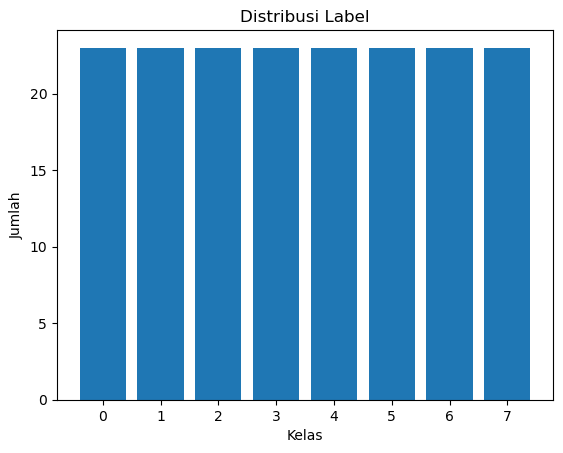

In [11]:
counter = Counter(dataset.labels)
plt.bar(counter.keys(), counter.values())
plt.title("Distribusi Label")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()


In [13]:
# Membagi dataset menjadi training dan validation
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

print(f"Data training: {len(train_dataset)}")
print(f"Data validation: {len(validation_dataset)}")


Data training: 128
Data validation: 56


In [14]:
# Load model pre-trained ResNet-18
model_resnet = models.resnet18(pretrained=True)

# Freeze semua layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Ganti fully connected layer terakhir
num_classes = 8  # Jumlah ekspresi
model_resnet.fc = nn.Sequential(
    nn.Linear(model_resnet.fc.in_features, 256),  # Layer tambahan
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, num_classes),  # Output untuk jumlah kelas
    nn.LogSoftmax(dim=1)  # LogSoftmax untuk klasifikasi
)

# Kirim model ke perangkat
model_resnet = model_resnet.to(device)
print(model_resnet)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Loss function dan optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# Jumlah epoch
num_epochs = 25

# History training
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model_resnet.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    # Validation phase
    model_resnet.eval()
    val_running_loss = 0.0
    val_running_corrects = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = val_running_corrects.double() / len(validation_dataset)
    valid_losses.append(val_epoch_loss)
    valid_accuracies.append(val_epoch_acc.item())

    print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

print("Training selesai!")


Epoch 1/25


100%|██████████| 4/4 [00:08<00:00,  2.23s/it]


Train Loss: 2.1824, Train Acc: 0.1094
Val Loss: 2.1864, Val Acc: 0.0536
Epoch 2/25


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Train Loss: 2.1031, Train Acc: 0.1641
Val Loss: 2.2749, Val Acc: 0.0357
Epoch 3/25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Train Loss: 2.0755, Train Acc: 0.1797
Val Loss: 2.2092, Val Acc: 0.0357
Epoch 4/25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Train Loss: 1.9941, Train Acc: 0.2031
Val Loss: 2.2613, Val Acc: 0.0179
Epoch 5/25


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Train Loss: 1.9279, Train Acc: 0.3125
Val Loss: 2.3099, Val Acc: 0.0000
Epoch 6/25


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 1.8720, Train Acc: 0.3281
Val Loss: 2.3558, Val Acc: 0.0179
Epoch 7/25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Train Loss: 1.8946, Train Acc: 0.2578
Val Loss: 2.4035, Val Acc: 0.0000
Epoch 8/25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Train Loss: 1.8242, Train Acc: 0.3359
Val Loss: 2.3996, Val Acc: 0.0000
Epoch 9/25


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Train Loss: 1.7383, Train Acc: 0.3906
Val Loss: 2.4352, Val Acc: 0.0000
Epoch 10/25


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 1.7429, Train Acc: 0.2969
Val Loss: 2.4948, Val Acc: 0.0179
Epoch 11/25


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Train Loss: 1.7358, Train Acc: 0.4141
Val Loss: 2.5311, Val Acc: 0.0179
Epoch 12/25


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Train Loss: 1.7119, Train Acc: 0.3750
Val Loss: 2.5220, Val Acc: 0.0179
Epoch 13/25


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 1.6514, Train Acc: 0.4375
Val Loss: 2.5609, Val Acc: 0.0000
Epoch 14/25


100%|██████████| 4/4 [00:08<00:00,  2.10s/it]


Train Loss: 1.6639, Train Acc: 0.3516
Val Loss: 2.5965, Val Acc: 0.0179
Epoch 15/25


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Train Loss: 1.6088, Train Acc: 0.4844
Val Loss: 2.6351, Val Acc: 0.0179
Epoch 16/25


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 1.5732, Train Acc: 0.4219
Val Loss: 2.6500, Val Acc: 0.0000
Epoch 17/25


100%|██████████| 4/4 [00:08<00:00,  2.16s/it]


Train Loss: 1.4955, Train Acc: 0.5156
Val Loss: 2.7190, Val Acc: 0.0000
Epoch 18/25


100%|██████████| 4/4 [00:08<00:00,  2.18s/it]


Train Loss: 1.4061, Train Acc: 0.5859
Val Loss: 2.7743, Val Acc: 0.0357
Epoch 19/25


100%|██████████| 4/4 [00:08<00:00,  2.19s/it]


Train Loss: 1.4502, Train Acc: 0.5234
Val Loss: 2.7994, Val Acc: 0.0357
Epoch 20/25


100%|██████████| 4/4 [00:08<00:00,  2.12s/it]


Train Loss: 1.3766, Train Acc: 0.5703
Val Loss: 2.7923, Val Acc: 0.0000
Epoch 21/25


100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Train Loss: 1.3422, Train Acc: 0.5781
Val Loss: 2.8710, Val Acc: 0.0000
Epoch 22/25


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Train Loss: 1.3446, Train Acc: 0.5859
Val Loss: 2.9449, Val Acc: 0.0179
Epoch 23/25


100%|██████████| 4/4 [00:08<00:00,  2.17s/it]


Train Loss: 1.2922, Train Acc: 0.5938
Val Loss: 2.9507, Val Acc: 0.0179
Epoch 24/25


100%|██████████| 4/4 [00:08<00:00,  2.11s/it]


Train Loss: 1.1475, Train Acc: 0.6641
Val Loss: 2.9827, Val Acc: 0.0179
Epoch 25/25


100%|██████████| 4/4 [00:08<00:00,  2.14s/it]


Train Loss: 1.2789, Train Acc: 0.5625
Val Loss: 2.9918, Val Acc: 0.0179
Training selesai!


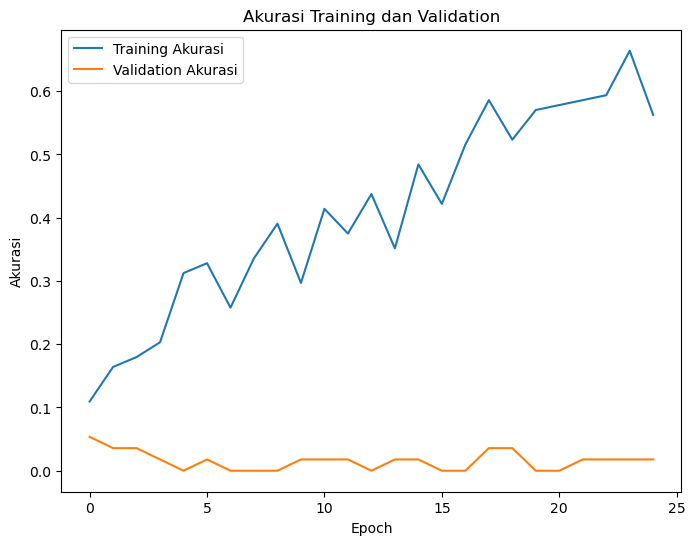

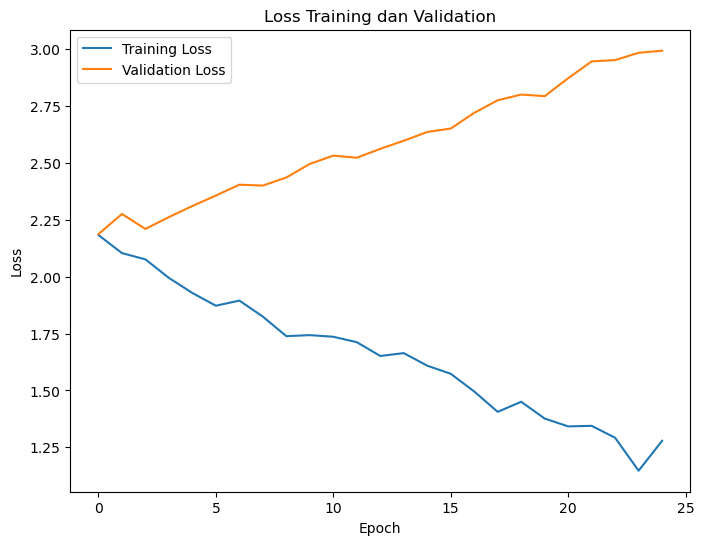

In [16]:
# 5. Visualisasi Skor Epoch

# Plot Akurasi
plt.figure(figsize=(8, 6))
plt.plot(train_accuracies, label='Training Akurasi')
plt.plot(valid_accuracies, label='Validation Akurasi')
plt.title('Akurasi Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Loss Training dan Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
